In [ ]:
#model imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller #to check stationarity
#from pandas_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose #for decomposing data
from statsmodels.tsa.arima.model import ARIMA #arima model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #plotting pacf & acf
import statsmodels.api as sm #sarima model
from sklearn.metrics import mean_squared_error #checking error 
from pmdarima.arima import auto_arima #finding optimum p&q values
import tensorflow as tf
tf.random.set_seed(7)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import warnings
warnings.filterwarnings('ignore')


### Importing Datas

In [3]:
#importing data
music_data=pd.read_csv('Music_sentiment_data.csv',parse_dates=['date'])
music_data.head(2)

,overall,asin,unixReviewTime,overall_split,date,text,text_token,positive,negative,neutral,compound,vader_sentiment
0,5,B000W18IN8,1363219200,0.0,2013-03-14,this song just makes me happy i love the beat ...,"['song', 'make', 'happy', 'love', 'beat', 'lyr...",0.338,0.056,0.606,0.9565,Positive
1,4,B00136JA8S,1405296000,0.0,2014-07-14,love this song it s catchy and you can dance t...,"['love', 'song', 'catchy', 'dance', 'four', 's...",0.259,0.000,0.741,0.6369,Positive


In [4]:
instrument_data=pd.read_csv('Instrument_sentiment_data.csv',parse_dates=['date'])
instrument_data.head(2)

,overall,asin,unixReviewTime,overall_split,date,text,text_token,positive,negative,neutral,compound,vader_sentiment
0,5,B000EELFTW,1485129600,0.0,2017-01-23,works well good quality recommend,"['work', 'well', 'good', 'quality', 'recommend']",0.789,0.000,0.211,0.7579,Positive
1,5,B003YOT65E,1490054400,0.0,2017-03-21,i don t expect much from a guitar i wanted a c...,"['expect', 'much', 'guitar', 'wanted', 'cheap'...",0.250,0.045,0.704,0.9929,Positive


In [5]:
music_data.shape

(239783, 12)

In [6]:
instrument_data.shape

(239865, 12)

In [7]:
music_data['vader_sentiment'].value_counts()

Positive    148844
Neutral      51469
Negative     20290
Conflict     19180
Name: vader_sentiment, dtype: int64

In [8]:
instrument_data['vader_sentiment'].value_counts()

Positive    138042
Neutral      50300
Negative     27847
Conflict     23676
Name: vader_sentiment, dtype: int64

### Seperating data into positive and negative

**Music Data**

In [9]:
music_pos_data=music_data[music_data['vader_sentiment']=='Positive']
music_pos_data['sentiment']=1
music_pos_data.head(2)

,overall,asin,unixReviewTime,overall_split,date,text,text_token,positive,negative,neutral,compound,vader_sentiment,sentiment
0,5,B000W18IN8,1363219200,0.0,2013-03-14,this song just makes me happy i love the beat ...,"['song', 'make', 'happy', 'love', 'beat', 'lyr...",0.338,0.056,0.606,0.9565,Positive,1
1,4,B00136JA8S,1405296000,0.0,2014-07-14,love this song it s catchy and you can dance t...,"['love', 'song', 'catchy', 'dance', 'four', 's...",0.259,0.000,0.741,0.6369,Positive,1


In [11]:
music_neg_data=music_data[music_data['vader_sentiment']=='Negative']
music_neg_data['sentiment']=1
music_neg_data.shape

(20290, 13)

In [12]:
music_pos=music_pos_data[['date','sentiment']]
music_pos

,date,sentiment
0,2013-03-14,1
1,2014-07-14,1
2,2013-06-23,1
3,2005-04-02,1
5,2015-11-16,1
...,...,...
239763,2017-06-06,1
239767,2013-01-27,1
239769,2014-11-29,1
239775,2000-07-31,1


In [13]:
music_neg=music_neg_data[['date','sentiment']]
music_neg

,date,sentiment
39,2012-03-22,1
236,2015-12-28,1
332,2013-02-07,1
341,2012-11-25,1
531,2016-09-06,1
...,...,...
239762,2013-06-27,1
239768,2016-07-06,1
239770,2015-09-11,1
239774,2002-03-03,1


In [14]:
music_pos.sort_values('date',inplace=True)
music_pos

,date,sentiment
3639,1997-11-28,1
65559,1998-06-10,1
75109,1998-06-21,1
179514,1998-07-17,1
206199,1998-07-18,1
...,...,...
80077,2018-09-23,1
42420,2018-09-24,1
87445,2018-09-26,1
125199,2018-09-28,1


In [15]:
music_neg.sort_values('date',inplace=True)
music_neg

,date,sentiment
139404,1998-06-11,1
239012,1998-11-12,1
192598,1999-04-29,1
129615,1999-05-25,1
179823,1999-06-04,1
...,...,...
151627,2018-09-05,1
184507,2018-09-06,1
130938,2018-09-10,1
196944,2018-09-10,1


In [16]:
music_pos=music_pos.set_index('date')
music_pos

,sentiment
date,
1997-11-28,1
1998-06-10,1
1998-06-21,1
1998-07-17,1
1998-07-18,1
...,...
2018-09-23,1
2018-09-24,1
2018-09-26,1


In [17]:
music_neg=music_neg.set_index('date')
music_neg

,sentiment
date,
1998-06-11,1
1998-11-12,1
1999-04-29,1
1999-05-25,1
1999-06-04,1
...,...
2018-09-05,1
2018-09-06,1
2018-09-10,1


In [18]:
music_resample=music_pos.resample('M')
music_pos_resample=music_resample.sum()
music_pos_resample

,sentiment
date,
1997-11-30,1
1997-12-31,0
1998-01-31,0
1998-02-28,0
1998-03-31,0
...,...
2018-06-30,294
2018-07-31,171
2018-08-31,107


In [19]:
music_resample=music_neg.resample('M')
music_neg_resample=music_resample.sum()
music_neg_resample

,sentiment
date,
1998-06-30,1
1998-07-31,0
1998-08-31,0
1998-09-30,0
1998-10-31,0
...,...
2018-05-31,108
2018-06-30,63
2018-07-31,39


**Instrument Data**

In [20]:
instrument_pos_data=instrument_data[instrument_data['vader_sentiment']=='Positive']
instrument_pos_data['sentiment']=1
instrument_pos_data.head(2)

,overall,asin,unixReviewTime,overall_split,date,text,text_token,positive,negative,neutral,compound,vader_sentiment,sentiment
0,5,B000EELFTW,1485129600,0.0,2017-01-23,works well good quality recommend,"['work', 'well', 'good', 'quality', 'recommend']",0.789,0.000,0.211,0.7579,Positive,1
1,5,B003YOT65E,1490054400,0.0,2017-03-21,i don t expect much from a guitar i wanted a c...,"['expect', 'much', 'guitar', 'wanted', 'cheap'...",0.250,0.045,0.704,0.9929,Positive,1


In [21]:
instrument_neg_data=instrument_data[instrument_data['vader_sentiment']=='Negative']
instrument_neg_data['sentiment']=1
instrument_neg_data.shape

(27847, 13)

In [22]:
instrument_pos=instrument_pos_data[['date','sentiment']]
instrument_pos

,date,sentiment
0,2017-01-23,1
1,2017-03-21,1
2,2014-02-21,1
3,2014-11-30,1
4,2015-01-04,1
...,...,...
239839,2013-08-08,1
239844,2012-03-25,1
239845,2016-03-16,1
239847,2015-01-02,1


In [23]:
instrument_neg=instrument_neg_data[['date','sentiment']]
instrument_neg

,date,sentiment
38,2015-12-22,1
60,2016-12-20,1
101,2014-10-05,1
251,2007-01-01,1
288,2017-05-30,1
...,...,...
239855,2015-05-03,1
239856,2016-01-04,1
239858,2018-03-20,1
239861,2016-01-01,1


In [24]:
instrument_pos.sort_values('date',inplace=True)
instrument_pos

,date,sentiment
36399,2000-01-05,1
154242,2000-01-20,1
138298,2000-04-01,1
68799,2000-07-15,1
103046,2000-10-29,1
...,...,...
11655,2018-09-29,1
239143,2018-09-29,1
16930,2018-09-30,1
196600,2018-10-01,1


In [25]:
instrument_neg.sort_values('date',inplace=True)
instrument_neg

,date,sentiment
224075,2001-02-28,1
215205,2001-11-14,1
123102,2001-11-23,1
125422,2002-05-30,1
216119,2002-06-19,1
...,...,...
133911,2018-09-20,1
161788,2018-09-20,1
183356,2018-09-20,1
225370,2018-09-21,1


In [26]:
instrument_pos=instrument_pos.set_index('date')
instrument_pos

,sentiment
date,
2000-01-05,1
2000-01-20,1
2000-04-01,1
2000-07-15,1
2000-10-29,1
...,...
2018-09-29,1
2018-09-29,1
2018-09-30,1


In [27]:
instrument_neg=instrument_neg.set_index('date')
instrument_neg

,sentiment
date,
2001-02-28,1
2001-11-14,1
2001-11-23,1
2002-05-30,1
2002-06-19,1
...,...
2018-09-20,1
2018-09-20,1
2018-09-20,1


In [28]:
instrument_resample=instrument_pos.resample('M')
instrument_pos_resample=instrument_resample.sum()
instrument_pos_resample

,sentiment
date,
2000-01-31,2
2000-02-29,0
2000-03-31,0
2000-04-30,1
2000-05-31,0
...,...
2018-06-30,1032
2018-07-31,769
2018-08-31,405


In [29]:
instrument_resample=instrument_neg.resample('M')
instrument_neg_resample=instrument_resample.sum()
instrument_neg_resample

,sentiment
date,
2001-02-28,1
2001-03-31,0
2001-04-30,0
2001-05-31,0
2001-06-30,0
...,...
2018-05-31,331
2018-06-30,234
2018-07-31,206


In [30]:
###############################################################

In [16]:
#function for decomposing data
def decompose(data,period=int):
    decomp=seasonal_decompose(data,period=period)
    trend=decomp.trend
    seasonal=decomp.seasonal
    residual=decomp.resid
    return(trend,seasonal,residual)

In [17]:
#function for visualizing decomposed data
def decompose_show(data,trend,seasonal,residual,name='data'):
    plt.figure(figsize=(9,9))
    plt.subplot(4,1,1)
    plt.plot(data,label=name,color='orange')
    plt.legend()
    plt.subplot(4,1,2)
    plt.plot(trend,label='Trend',color='green')
    plt.legend()
    plt.subplot(4,1,3)
    plt.plot(seasonal,label='Seasonal',color='black')
    plt.legend()
    plt.subplot(4,1,4)
    plt.plot(residual,label='Noise',color='red')
    plt.legend();

In [186]:
trend1,seasonal1,residual1=decompose(music_pos_resample,12)
trend2,seasonal2,residual2=decompose(music_neg_resample,12)

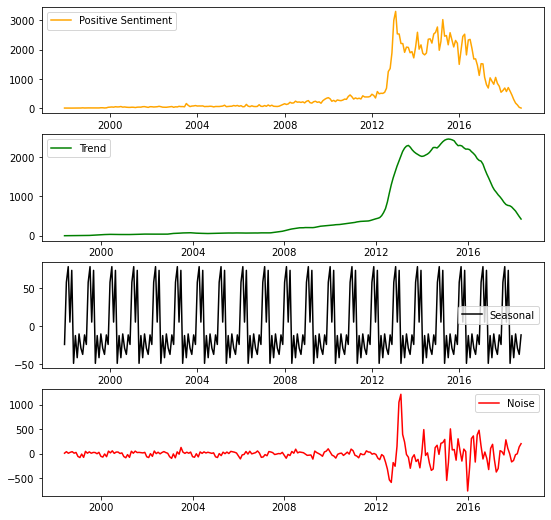

In [187]:
decompose_show(music_pos_resample,trend1,seasonal1,residual1,"Positive Sentiment")

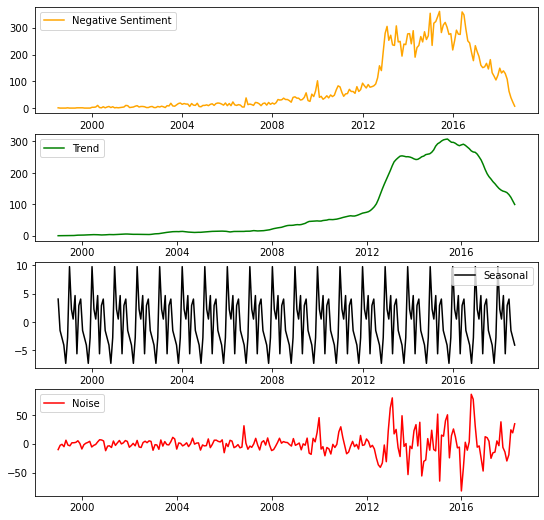

In [188]:
decompose_show(music_neg_resample,trend2,seasonal2,residual2,"Negative Sentiment")

In [23]:
#function for checking stationarity of data
def checkstationarity(data):
    pvalue=adfuller(data)[1]
    if pvalue<0.05:
        do='Data is stationary. Do model building.'
    else:
        do='Data is not stationary. Make data as stationary'
    return(do)

In [189]:
checkstationarity(music_pos_resample)

'Data is not stationary. Make data as stationary'

In [190]:
checkstationarity(music_neg_resample)

'Data is not stationary. Make data as stationary'

In [26]:
#function for plotting acf and pacf plots
def pqplot(data,lags=int):
    fig,ax=plt.subplots(1,2,figsize=(16,8))
    plot_acf(data,lags=lags,ax=ax[0])
    plot_pacf(data,lags=lags,ax=ax[1])
    plt.show()

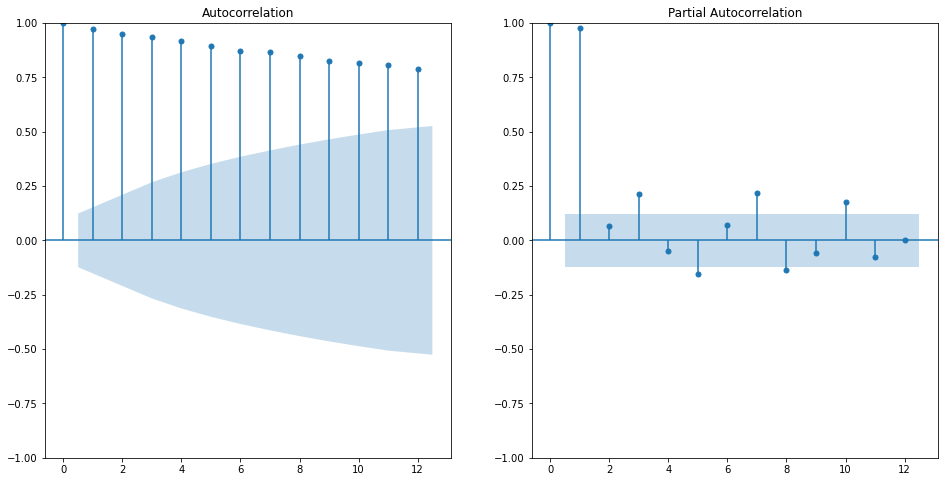

In [191]:
pqplot(music_pos_resample,12)

p-1,q-12

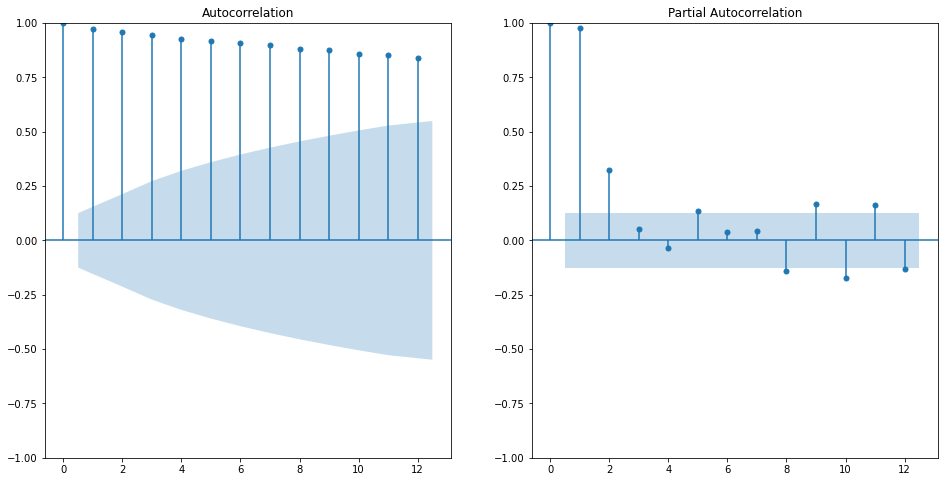

In [192]:
pqplot(music_neg_resample,12)

In [29]:
#function for splitting data
def split(data,split=0.8):
    num = int(split * len(data))
    train = data.iloc[:num]
    test = data.iloc[num:]
    return train,test

In [193]:
pos_train,pos_test=split(music_pos_resample)
neg_train,neg_test=split(music_neg_resample,0.9)

In [36]:
#user defined function to get optimum p&q values of sarima model
def sarima_values(data,a=2,b=2,d=12):
    values1=[]
    for p in range(a):
        for q in range(b):
            values1.append((p,1,q))
    values2=[]
    for p in range(a):
        for q in range(b):
            values2.append((p,1,q,d))            
    model=[]
    for i,j in zip(values1,values2):
            m=sm.tsa.statespace.SARIMAX(data,order=i,seasonal_order=(j)).fit()
            model.append(m)
    values1
    aic=[]
    bic=[]
    RMSE=[]
    for i in model[0:]:
        aic.append(i.aic)
        bic.append(i.bic)
        h=mean_squared_error(data,i.fittedvalues,squared=False)
        RMSE.append(h)
    x=min(aic)
    y=min(bic)
    z=min(RMSE)
    m=values1[aic.index(x)]
    n=values1[bic.index(y)]
    o=values1[RMSE.index(z)]
    return(m,n,o)

In [32]:
#user defined function to predict train data
def train_prediction(model,train,test):
    train_predictions = model.predict(0,len(train)-1)
    result=pd.DataFrame()
    result['Actual']=train
    result['Train_Predicted']=train_predictions
    return(result)

In [33]:
#user defined function to predict test data
def test_prediction(model,train,test):
    test_predictions = model.predict(start=len(train)-1,end=len(train)+len(test)-1,dynamic=True)
    result=pd.DataFrame()
    result['Actual']=test
    result['Test_Predicted']=test_predictions
    return(result)

**Sarima**

In [34]:
sarima_values(pos_train,1,12,12) #optimum p&q values of aic,bic & rmse

((0, 2, 4), (0, 2, 3), (0, 2, 11))

In [56]:
p=3; q=3; d=1
model1 = sm.tsa.statespace.SARIMAX(pos_train,order=(p,d,q),seasonal_order=(p,d,q,12)).fit() #sarima model
model1.summary() #getting summary of model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          sentiment   No. Observations:                  201
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood               -1180.591
Date:                            Tue, 06 Dec 2022   AIC                           2387.181
Time:                                    12:12:32   BIC                           2429.255
Sample:                                11-30-1997   HQIC                          2404.228
                                     - 07-31-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4030      0.176      2.290      0.022       0.058       0.748
ar.L2         -0.7704      0.162     -4.748      0.000      -1.088      -0.452
ar.L3         -0.0921      0.171     -0.540      0.589      -0.427       0.242
ma.L1         -0.1346      0.194     -0.694      0.488      -0.515       0.245
ma.L2          0.6782      0.357      1.898      0.058      -0.022       1.378
ma.L3          0.5017      0.284      1.769      0.077      -0.054       1.057
ar.S.L12      -0.9979     12.566     -0.079      0.937     -25.626      23.630
ar.S.L24      -0.0982     13.097     -0.007      0.994     -25.768      25.571
ar.S.L36       0.1697      5.483      0.031      0.975     -10.576      10.915
ma.S.L12       0.4121     12.614      0.033      0.974     -24.311      25.135
ma.S.L24      -0.0559      6.482     -0.009      0.993     -12.760      12.648
ma.S.L36       0.0337      3.170      0.011      0.992      -6.180       6.247
sigma2      2.088e+04   9382.483      2.225      0.026    2487.057    3.93e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2107.77
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              73.07   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
#getting train predictons
train_result1=train_prediction(model1,pos_train,pos_test)
train_result1.head()

,Actual,Train_Predicted
date,,
1997-11-30,1,0.000000
1997-12-31,0,1.004943
1998-01-31,0,-0.009471
1998-02-28,0,0.002153
1998-03-31,0,-0.005039


In [58]:
#getting test predictions
test_result1=test_prediction(model1,pos_train,pos_test)
test_result1.tail()

,Actual,Test_Predicted
date,,
2018-06-30,294,4437.022445
2018-07-31,171,4607.549551
2018-08-31,107,4610.740841
2018-09-30,26,4673.056914
2018-10-31,1,4768.790472


In [59]:
#forecasting values
forecast1=model1.predict(len(music_pos)-1,len(music_pos)+12)

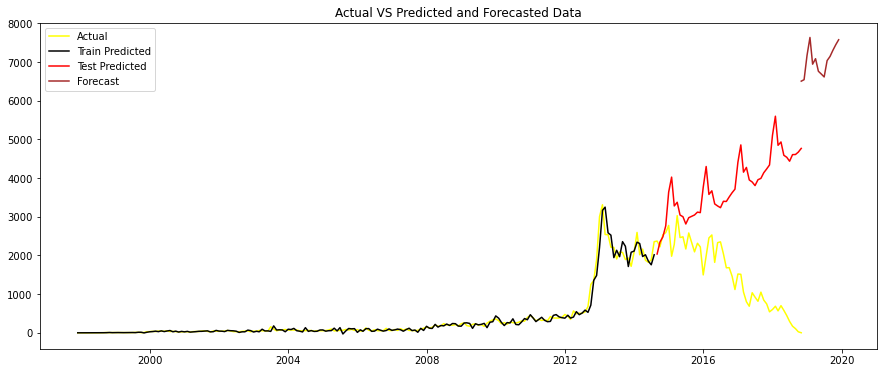

In [62]:
#plot for forecasted values
plt.figure(figsize=(15,6))
plt.title('Actual VS Predicted and Forecasted Data')
plt.plot(music_pos,label='Actual',color='yellow')
plt.plot(train_result1.Train_Predicted,label='Train Predicted',color='black')
plt.plot(test_result1.Test_Predicted,label='Test Predicted',color='red')
plt.plot(forecast1,label='Forecast',color='brown')
plt.legend();

**Arima**

In [64]:
def arima_values(train,test,name,p,d,q):
    # different p and q values, calculate AIC and BIC
    # Model No (p,d,q) AIC and BIC,MSE,RMSE
    p = np.arange(p)
    q = np.arange(q)
    aic_li = []
    bic_li = []
    MSE_li = []
    RMSE_li = []
    model = []
    mae_li = []
    p_li=[]
    q_li=[]
    if name=='arima':
        for i in p:
            for j in q:
                m = ARIMA(train,order=(i,d,j)).fit()
                aic_li.append(m.aic)
                bic_li.append(m.bic)
                predicted = m.fittedvalues
                forecast_tep = m.forecast(len(test))
                mse = mean_squared_error(test, forecast_tep) 
                rmse= mean_squared_error(test, forecast_tep,squared= False)
                mae= mean_absolute_error(test,forecast_tep)
                MSE_li.append(mse)
                RMSE_li.append(rmse)
                mae_li.append(mae)
                p_li.append(i)
                q_li.append(j)
            # dataframe
        score= pd.DataFrame({'p':p_li,'q':q_li,'AIC':aic_li,'BIC':bic_li,'MSE':MSE_li,'RMSE':RMSE_li,'MAE':mae_li}) 

        return(score)

In [69]:
score = arima_values(pos_train,pos_test,'arima',5,1,5) #optimum p&q values of aic,bic & rmse
score.sort_values(by='RMSE',ascending=True).head(10)

,p,q,AIC,BIC,MSE,RMSE,MAE
23,4,3,2554.033467,2580.420006,1.394585e+06,1180.925284,921.082843
17,3,2,2563.211737,2583.001641,1.408126e+06,1186.644684,918.897884
24,4,4,2556.383079,2586.067935,1.416202e+06,1190.042865,929.717974
9,1,4,2562.784874,2582.574778,1.417474e+06,1190.576962,921.639460
21,4,1,2561.925616,2581.715520,1.433939e+06,1197.471936,927.143113
0,0,0,2558.501312,2561.799630,1.445152e+06,1202.144840,932.764706
22,4,2,2547.962696,2571.050917,1.458619e+06,1207.733162,947.862513
19,3,4,2548.348350,2574.734889,1.484409e+06,1218.363375,945.669951
6,1,1,2559.341473,2569.236425,1.534015e+06,1238.553682,965.338346
14,2,4,2546.157227,2569.245448,1.534486e+06,1238.743726,963.270676


In [70]:
p=4; q=3; d=1
model2 = ARIMA(pos_train,order = (p,d,q)).fit() #arima model
model2.summary() #getting summary of model

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              sentiment   No. Observations:                  201
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1269.017
Date:                Tue, 06 Dec 2022   AIC                           2554.033
Time:                        12:25:36   BIC                           2580.420
Sample:                    11-30-1997   HQIC                          2564.712
                         - 07-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8762      0.206      9.122      0.000       1.473       2.279
ar.L2         -1.8467      0.245     -7.546      0.000      -2.326      -1.367
ar.L3          0.8705      0.222      3.915      0.000       0.435       1.306
ar.L4         -0.0601      0.067     -0.902      0.367      -0.191       0.071
ma.L1         -1.7782      0.195     -9.113      0.000      -2.161      -1.396
ma.L2          1.7800      0.205      8.691      0.000       1.379       2.181
ma.L3         -0.8609      0.189     -4.564      0.000      -1.231      -0.491
sigma2      2.079e+04   1786.468     11.638      0.000    1.73e+04    2.43e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              5424.39
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):             172.92   Skew:                             1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
#getting train predictons
train_result2=train_prediction(model2,pos_train,pos_test)
train_result2.head()

,Actual,Train_Predicted
date,,
1997-11-30,1,0.000000
1997-12-31,0,1.003911
1998-01-31,0,-0.164123
1998-02-28,0,-0.029582
1998-03-31,0,0.091904


In [72]:
#getting test predictions
test_result2=test_prediction(model2,pos_train,pos_test)
test_result2.tail()

,Actual,Test_Predicted
date,,
2018-06-30,294,2053.555051
2018-07-31,171,2052.245369
2018-08-31,107,2067.101706
2018-09-30,26,2082.900300
2018-10-31,1,2085.042818


In [73]:
#forecasting values
forecast2=model2.predict(len(music_pos)-1,len(music_pos)+12)

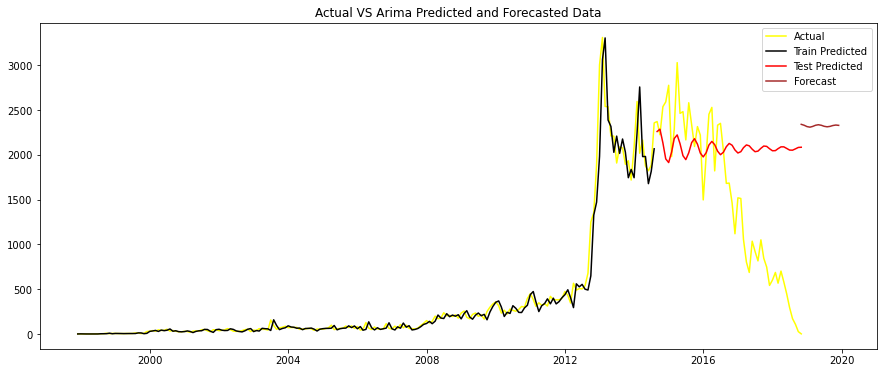

In [75]:
#plot for forecasted values
plt.figure(figsize=(15,6))
plt.title('Actual VS Arima Predicted and Forecasted Data')
plt.plot(music_pos,label='Actual',color='yellow')
plt.plot(train_result2.Train_Predicted,label='Train Predicted',color='black')
plt.plot(test_result2.Test_Predicted,label='Test Predicted',color='red')
plt.plot(forecast2,label='Forecast',color='brown')
plt.legend();

In [76]:
################################################################################

In [63]:
################################################################################

### Music Data

In [78]:
!pip install tensorflow

**Music Positive Data**

In [32]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
    X, y =[],[]
    for i in range(len(timeseries_data)):
# find the end of this pattern
        end_ix = i + n_features
# check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
         break
# gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [98]:
pos_music = music_pos_resample.copy()

In [99]:
pos_music.reset_index()

,date,sentiment
0,1997-11-30,1
1,1997-12-31,0
2,1998-01-31,0
3,1998-02-28,0
4,1998-03-31,0
...,...,...
247,2018-06-30,294
248,2018-07-31,171
249,2018-08-31,107
250,2018-09-30,26


In [180]:
music_pos_train = pos_music[0:252-12]
music_pos_test_12 = pos_music[252-12:]
music_pos_test_20 = pos_music[252-21:]

In [181]:
print(len(music_pos_train))
print(len(music_pos_test_12))
print(len(music_pos_test_20))

240
12
21


In [182]:
n_steps = 20
pos_X_music_tra, pos_y_music_tra = prepare_data(music_pos_train['sentiment'], n_steps)
pos_X_music_tes, pos_y_music_tes = prepare_data(music_pos_test_20['sentiment'], n_steps)

In [183]:
print(pos_X_music_tes)

[[1055  803  687 1036  922  816 1051  846  747  542  602  687  567  702
   581  445  294  171  107   26]]


In [184]:
print(pos_y_music_tes)

[1]


In [103]:
print(pos_X_music_tra)

[[   1    0    0 ...    5    5    5]
 [   0    0    0 ...    5    5   11]
 [   0    0    0 ...    5   11   11]
 ...
 [1497 1982 2453 ... 1036  922  816]
 [1982 2453 2530 ...  922  816 1051]
 [2453 2530 1821 ...  816 1051  846]]


In [104]:
print(pos_y_music_tra)

[  11   11    4    8   27   31   38   31   46   39   41   53   32   39
   30   25   24   30   27   19   31   34   32   47   50   36   24   47
   46   37   40   46   60   48   31   29   28   37   48   53   27   44
   39   60   51   52   44  156   94   52   69   74   86   70   73   71
   74   51   56   55   63   58   41   55   53   54   60   69   98   49
   57   62   64   88   72   90   62   83   44   51  127   65   50   78
   56   53   56  115   62   57   87   61  106   69   98   62   60   55
   65   94  118  149  124  142  199  170  178  237  202  209  194  213
  177  233  256  186  170  218  234  197  213  166  251  299  335  357
  316  233  265  222  279  263  254  274  307  300  396  450  385  309
  348  319  338  312  420  382  381  381  398  474  431  346  566  490
  507  503  539  679 1250 1354 1891 3005 3311 2541 2537 2212 2208 1909
 2088 2078 1894 1934 1719 2088 2596 2018 2165 1876 1822 1886 2357 2372
 2225 2538 2591 2777 1980 2287 3030 2463 2483 2167 2582 2330 2093 2316
 2221 

In [105]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
pos_X_music = pos_X_music_tra.reshape((pos_X_music_tra.shape[0], pos_X_music_tra.shape[1], n_features))

In [106]:
# define model
def lstm(X,y,n_steps,n_features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X,y, epochs=300, verbose=1)
    return model

In [107]:
pos_model_music = lstm(pos_X_music,pos_y_music_tra,20,1)

Epoch 1/300
7/7 [==============================] - 3s 9ms/step - loss: 828976.7500
Epoch 2/300
7/7 [==============================] - 0s 9ms/step - loss: 792866.6875
Epoch 3/300
7/7 [==============================] - 0s 11ms/step - loss: 746104.0000
Epoch 4/300
7/7 [==============================] - 0s 10ms/step - loss: 726493.3750
Epoch 5/300
7/7 [==============================] - 0s 11ms/step - loss: 533935.2500
Epoch 6/300
7/7 [==============================] - 0s 11ms/step - loss: 617694.5625
Epoch 7/300
7/7 [==============================] - 0s 10ms/step - loss: 472906.9062
Epoch 8/300
7/7 [==============================] - 0s 11ms/step - loss: 496957.5625
Epoch 9/300
7/7 [==============================] - 0s 11ms/step - loss: 247386.1406
Epoch 10/300
7/7 [==============================] - 0s 10ms/step - loss: 497716.4062
Epoch 11/300
7/7 [==============================] - 0s 11ms/step - loss: 332926.1875
Epoch 12/300
7/7 [==============================] - 0s 11ms/step - loss: 133

In [108]:
pos_y_music_tra

array([  11,   11,    4,    8,   27,   31,   38,   31,   46,   39,   41,
         53,   32,   39,   30,   25,   24,   30,   27,   19,   31,   34,
         32,   47,   50,   36,   24,   47,   46,   37,   40,   46,   60,
         48,   31,   29,   28,   37,   48,   53,   27,   44,   39,   60,
         51,   52,   44,  156,   94,   52,   69,   74,   86,   70,   73,
         71,   74,   51,   56,   55,   63,   58,   41,   55,   53,   54,
         60,   69,   98,   49,   57,   62,   64,   88,   72,   90,   62,
         83,   44,   51,  127,   65,   50,   78,   56,   53,   56,  115,
         62,   57,   87,   61,  106,   69,   98,   62,   60,   55,   65,
         94,  118,  149,  124,  142,  199,  170,  178,  237,  202,  209,
        194,  213,  177,  233,  256,  186,  170,  218,  234,  197,  213,
        166,  251,  299,  335,  357,  316,  233,  265,  222,  279,  263,
        254,  274,  307,  300,  396,  450,  385,  309,  348,  319,  338,
        312,  420,  382,  381,  381,  398,  474,  4

In [109]:
pos_y_music_tra[-20:]

array([2530, 1821, 2332, 2352, 2044, 1681, 1685, 1462, 1119, 1520, 1513,
       1055,  803,  687, 1036,  922,  816, 1051,  846,  747], dtype=int64)

In [168]:
# demonstrate prediction for next 10 days
def forecast(model,pred_data,months,n_steps,n_features):
    x_input = np.array(pred_data)
    temp_input=list(x_input)
    lst_output=[]
    i=0
    while(i<months):

        if(len(temp_input)>n_steps):
            x_input=np.array(temp_input[1:])
            x_input = x_input.reshape((1, n_steps, n_features))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])
            temp_input=temp_input[1:]
            lst_output.append(yhat[0][0])
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps, n_features))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])
            lst_output.append(yhat[0][0])
            i=i+1


    return (lst_output)

In [153]:
len(pos_y_music_tes)

0

In [169]:
pos_forecast_music=forecast(pos_model_music,pos_y_music_tra[-20:],12,20,1)

In [170]:
pos_forecast_music

[1015.9709,
 561.2144,
 1055.298,
 598.9306,
 939.9703,
 480.80948,
 103.87187,
 731.5902,
 717.6883,
 728.8405,
 417.64575,
 597.0378]

In [113]:
len(music_pos_train['sentiment'])

240

In [189]:
pos_forecast_music_36=forecast(pos_model_music,pos_y_music_tra[-20:],36,20,1)

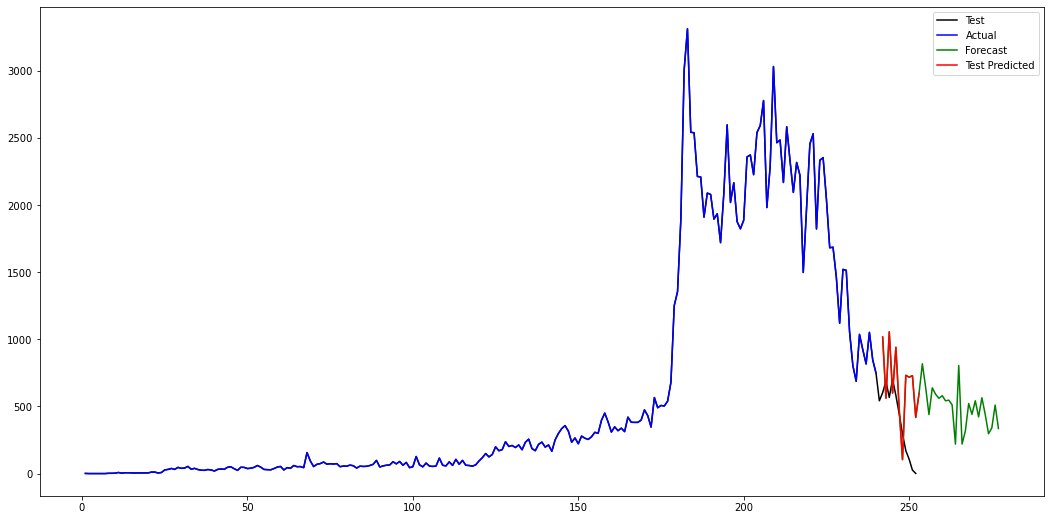

In [196]:
day_new=np.arange(1,241)
day_new1=np.arange(1,253)
day_pred=np.arange(242,242+12)
day_forecast=np.arange(242,242+36)
plt.figure(figsize=(18,9))
plt.plot(day_new1,pos_music['sentiment'],color='black',label='Test')
plt.plot(day_new,music_pos_train['sentiment'],color='b',label='Actual')
plt.plot(day_forecast,pos_forecast_music_36,color='green',label='Forecast')
plt.plot(day_pred,pos_forecast_music,color='red',label='Test Predicted')
plt.legend()
plt.show()

**Music Negative Data**

In [197]:
neg_music = music_neg_resample.copy()

In [198]:
neg_music.reset_index()

,date,sentiment
0,1998-06-30,1
1,1998-07-31,0
2,1998-08-31,0
3,1998-09-30,0
4,1998-10-31,0
...,...,...
239,2018-05-31,108
240,2018-06-30,63
241,2018-07-31,39
242,2018-08-31,22


In [199]:
music_neg_train = neg_music[0:244-12]
music_neg_test_12 = neg_music[244-12:]
music_neg_test_20 = neg_music[244-21:]

In [201]:
n_steps = 20
neg_X_music, neg_y_music = prepare_data(music_neg_train['sentiment'], n_steps)

In [234]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
neg_X_music = neg_X_music.reshape((neg_X_music.shape[0], neg_X_music.shape[1], n_features))

In [249]:
neg_model_music = lstm(neg_X_music,neg_y_music,20,1)

Epoch 1/300
7/7 [==============================] - 6s 19ms/step - loss: 23857.3828
Epoch 2/300
7/7 [==============================] - 0s 18ms/step - loss: 16312.6484
Epoch 3/300
7/7 [==============================] - 0s 19ms/step - loss: 12909.8193
Epoch 4/300
7/7 [==============================] - 0s 19ms/step - loss: 8088.8188
Epoch 5/300
7/7 [==============================] - 0s 19ms/step - loss: 7311.0562
Epoch 6/300
7/7 [==============================] - 0s 20ms/step - loss: 5385.5859
Epoch 7/300
7/7 [==============================] - 0s 18ms/step - loss: 4918.9575
Epoch 8/300
7/7 [==============================] - 0s 19ms/step - loss: 3819.8125
Epoch 9/300
7/7 [==============================] - 0s 19ms/step - loss: 2515.3223
Epoch 10/300
7/7 [==============================] - 0s 19ms/step - loss: 2533.8745
Epoch 11/300
7/7 [==============================] - 0s 19ms/step - loss: 2320.3796
Epoch 12/300
7/7 [==============================] - 0s 18ms/step - loss: 2083.1042
Epoch 13/3

In [250]:
neg_forecast_music=forecast(neg_model_music,neg_y_music[-20:],12,20,1)

In [251]:
neg_forecast_music

[90.26199,
 92.735916,
 100.27504,
 85.61385,
 97.31262,
 102.48453,
 65.7171,
 92.85733,
 49.872692,
 43.044758,
 76.97018,
 57.60724]

In [252]:
neg_forecast_music_36=forecast(neg_model_music,neg_y_music[-20:],36,20,1)

In [253]:
len(pos_y_music_tra)

220

In [254]:
len(music_neg_train['sentiment'])

232

In [ ]:
day_new=np.arange(1,233)
day_new1=np.arange(1,245)
day_pred=np.arange(234,234+12)
day_forecast=np.arange(234,234+36)
plt.figure(figsize=(18,9))
plt.plot(day_new1,neg_music['sentiment'],color='black',label='Test')
plt.plot(day_new,music_neg_train['sentiment'],color='b',label='Actual')
plt.plot(day_forecast,neg_forecast_music_36,color='green',label='Forecast')
plt.plot(day_pred,neg_forecast_music,color='red',label='Test Predicted')
plt.legend()
plt.show()

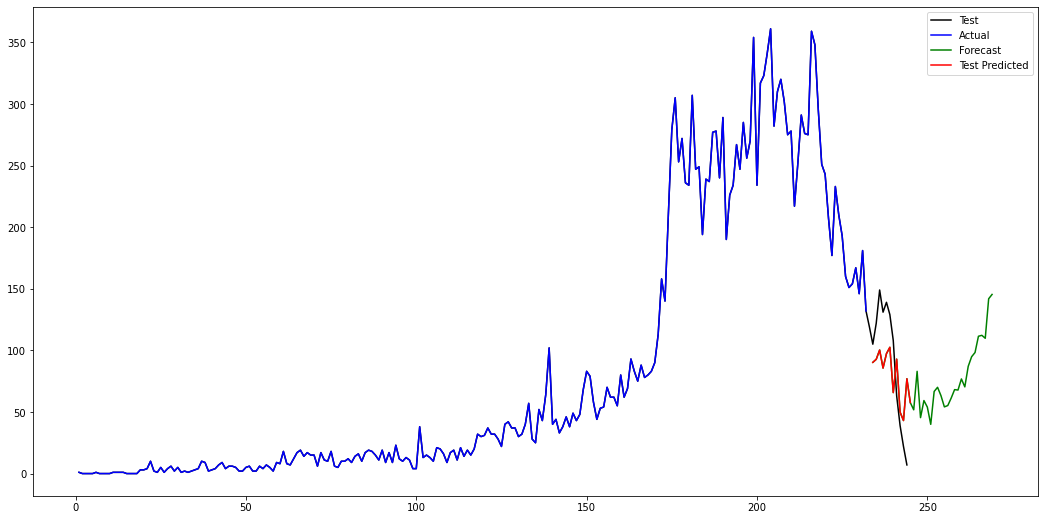

In [255]:
day_new=np.arange(1,233)
day_new1=np.arange(1,245)
day_pred=np.arange(234,234+12)
day_forecast=np.arange(234,234+36)
plt.figure(figsize=(18,9))
plt.plot(day_new1,neg_music['sentiment'],color='black',label='Test')
plt.plot(day_new,music_neg_train['sentiment'],color='b',label='Actual')
plt.plot(day_forecast,neg_forecast_music_36,color='green',label='Forecast')
plt.plot(day_pred,neg_forecast_music,color='red',label='Test Predicted')
plt.legend()
plt.show()

### Instrument Data

**Positive data**

In [256]:
pos_instrument = instrument_pos_resample.copy()

In [257]:
pos_instrument.reset_index()

,date,sentiment
0,2000-01-31,2
1,2000-02-29,0
2,2000-03-31,0
3,2000-04-30,1
4,2000-05-31,0
...,...,...
221,2018-06-30,1032
222,2018-07-31,769
223,2018-08-31,405
224,2018-09-30,158


In [258]:
instrument_pos_train = pos_instrument[0:226-12]
instrument_pos_test_12 = pos_instrument[226-12:]
instrument_pos_test_20 = pos_instrument[226-21:]

In [259]:
n_steps = 20
pos_X_instrument, pos_y_instrument = prepare_data(instrument_pos_train['sentiment'], n_steps)

In [260]:
print(pos_X_instrument)

[[   2    0    0 ...    0    0    4]
 [   0    0    1 ...    0    4    1]
 [   0    1    0 ...    4    1    3]
 ...
 [2119 2816 2361 ... 1753 1578 1579]
 [2816 2361 2695 ... 1578 1579 1589]
 [2361 2695 2105 ... 1579 1589 1673]]


In [261]:
print(pos_y_instrument)

[   1    3    1    3    0    2    0    0    2    0    0    0    2    1
    2    1    5    1    6    2    0    3    4    3    4    3    2   11
    5    2    4    2    4    7    3    8    7    6   12   17   14    8
   12   10    9   10   16    9   20   21   18   32   23   18   32   14
   15   20   19   25   12   21   33   40   89   31   58   30   39   28
   37   32   31   39   38   74   98   55   55   45   79   68   63   73
   76   54   72  104  151  101   96   87  102  109   95  115  114  120
  125  166  216  232  231  169  199  185  210  203  197  225  238  365
  446  284  345  302  307  336  327  368  382  410  427  605  638  485
  471  471  392  412  434  465  457  562  681 1331 1621 1255 1276 1104
 1042  976 1031 1071 1016 1177 1081 1613 1986 1437 1547 1279 1253 1164
 1508 1618 1663 1678 1664 2317 2629 2269 2374 1984 1940 1876 1923 1981
 1935 2077 2090 2119 2816 2361 2695 2105 2315 2211 2207 2287 2234 2177
 2055 2957 3134 2158 2338 1945 1753 1578 1579 1589 1673 1473]


In [262]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
pos_X = pos_X_instrument.reshape((pos_X_instrument.shape[0], pos_X_instrument.shape[1], n_features))

In [284]:
pos_model_instrument = lstm(pos_X_instrument,pos_y_instrument,20,1)

Epoch 1/300
7/7 [==============================] - 6s 19ms/step - loss: 620998.2500
Epoch 2/300
7/7 [==============================] - 0s 18ms/step - loss: 317356.7500
Epoch 3/300
7/7 [==============================] - 0s 18ms/step - loss: 233450.5312
Epoch 4/300
7/7 [==============================] - 0s 18ms/step - loss: 177384.2500
Epoch 5/300
7/7 [==============================] - 0s 17ms/step - loss: 320178.0312
Epoch 6/300
7/7 [==============================] - 0s 18ms/step - loss: 226746.7969
Epoch 7/300
7/7 [==============================] - 0s 19ms/step - loss: 141224.2812
Epoch 8/300
7/7 [==============================] - 0s 18ms/step - loss: 141508.5312
Epoch 9/300
7/7 [==============================] - 0s 18ms/step - loss: 95738.2344
Epoch 10/300
7/7 [==============================] - 0s 17ms/step - loss: 103594.2500
Epoch 11/300
7/7 [==============================] - 0s 18ms/step - loss: 105659.5078
Epoch 12/300
7/7 [==============================] - 0s 19ms/step - loss: 79

In [285]:
pos_forecast_instrument=forecast(pos_model_instrument,pos_y_instrument[-20:],12,20,1)

In [286]:
len(instrument_pos_train['sentiment'])

214

In [287]:
pos_forecast_instrument_36=forecast(pos_model_instrument,pos_y_instrument[-20:],36,20,1)

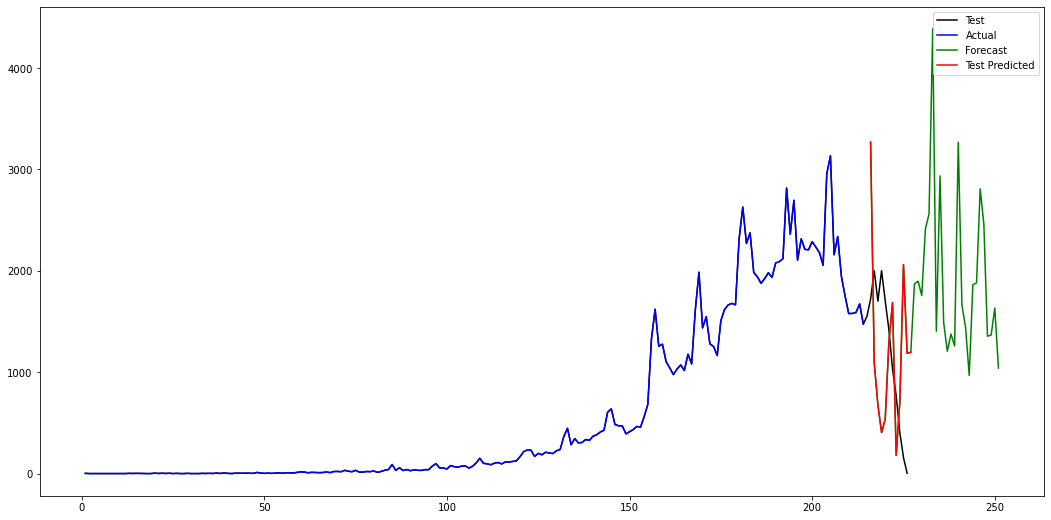

In [288]:
day_new=np.arange(1,215)
day_new1=np.arange(1,227)
day_pred=np.arange(216,216+12)
day_forecast=np.arange(216,216+36)
plt.figure(figsize=(18,9))
plt.plot(day_new1,pos_instrument['sentiment'],color='black',label='Test')
plt.plot(day_new,instrument_pos_train['sentiment'],color='b',label='Actual')
plt.plot(day_forecast,pos_forecast_instrument_36,color='green',label='Forecast')
plt.plot(day_pred,pos_forecast_instrument,color='red',label='Test Predicted')
plt.legend()
plt.show()

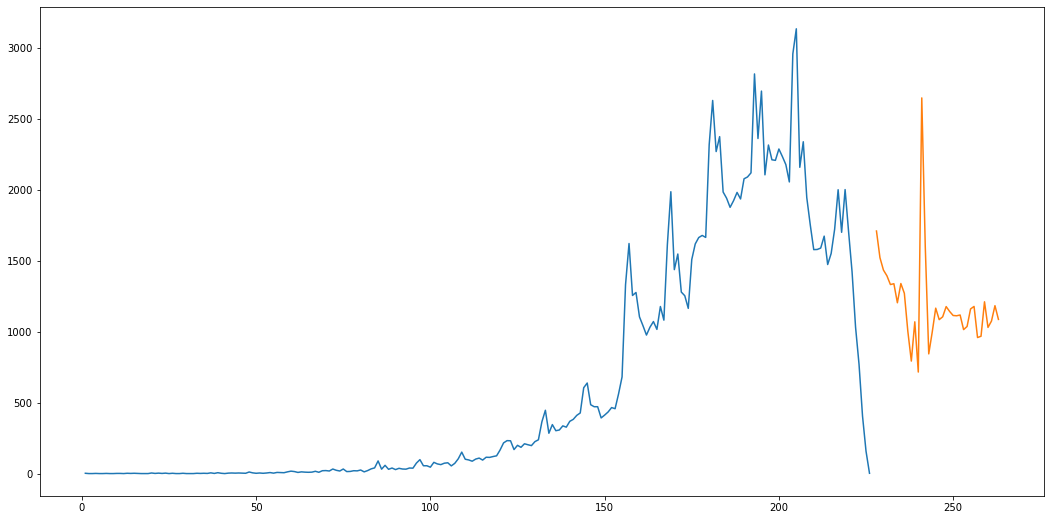

In [246]:
day_new=np.arange(1,227)
day_pred=np.arange(228,264)
plt.figure(figsize=(18,9))
plt.plot(day_new,pos_instrument['sentiment'])
plt.plot(day_pred,pos_forecast_instrument)
plt.show()

**Negative data**

In [289]:
neg_instrument = instrument_neg_resample.copy()

In [290]:
neg_instrument.reset_index()

,date,sentiment
0,2001-02-28,1
1,2001-03-31,0
2,2001-04-30,0
3,2001-05-31,0
4,2001-06-30,0
...,...,...
207,2018-05-31,331
208,2018-06-30,234
209,2018-07-31,206
210,2018-08-31,116


In [291]:
instrument_neg_train = neg_instrument[0:212-12]
instrument_neg_test_12 = neg_instrument[212-12:]
instrument_neg_test_20 = neg_instrument[212-21:]

In [292]:
n_steps = 20
neg_X_instrument, neg_y_instrument = prepare_data(instrument_neg_train['sentiment'], n_steps)

In [293]:
print(neg_X_instrument)

[[  1   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [416 492 532 ... 451 430 377]
 [492 532 504 ... 430 377 400]
 [532 504 462 ... 377 400 436]]


In [294]:
print(neg_y_instrument)

[  0   0   1   0   1   1   0   1   2   1   0   1   1   2   3   5   1   3
   1   4   0   2   2   2   1   1   2   1   3   2   2   5   2   1   2   3
   7   5   4   8   8   7   3   2   8   3   3   3   3   7   8  24   6   2
   6  10   3  11  11   7  15   7  18  19   9  15  11   9   6   7  17  15
  11  10  19  33  17  18  21  15  19  18  11  20  30  20  35  29  40  37
  31  34  38  47  27  43  51  46  81  76  53  70  54  58  64  61  63  75
  82  79 115 154  82  99  81  99  89  95  80  86 101 141 252 260 180 204
 185 191 198 152 189 188 234 205 336 317 284 285 223 229 200 252 309 296
 315 294 437 465 376 413 402 349 372 399 409 352 405 416 492 532 504 462
 427 471 424 435 492 441 444 414 601 577 477 502 451 430 377 400 436 376]


In [295]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
neg_X = neg_X_instrument.reshape((neg_X_instrument.shape[0], neg_X_instrument.shape[1], n_features))

In [351]:
neg_model_instrument = lstm(neg_X_instrument,neg_y_instrument,20,1)

Epoch 1/300
6/6 [==============================] - 8s 19ms/step - loss: 44597.6445
Epoch 2/300
6/6 [==============================] - 0s 20ms/step - loss: 34069.3750
Epoch 3/300
6/6 [==============================] - 0s 18ms/step - loss: 16678.5645
Epoch 4/300
6/6 [==============================] - 0s 19ms/step - loss: 14426.4639
Epoch 5/300
6/6 [==============================] - 0s 19ms/step - loss: 6673.4165
Epoch 6/300
6/6 [==============================] - 0s 19ms/step - loss: 5137.4453
Epoch 7/300
6/6 [==============================] - 0s 19ms/step - loss: 8967.3213
Epoch 8/300
6/6 [==============================] - 0s 20ms/step - loss: 11063.2148
Epoch 9/300
6/6 [==============================] - 0s 20ms/step - loss: 14827.9766
Epoch 10/300
6/6 [==============================] - 0s 20ms/step - loss: 23400.9023
Epoch 11/300
6/6 [==============================] - 0s 20ms/step - loss: 19463.6035
Epoch 12/300
6/6 [==============================] - 0s 19ms/step - loss: 12916.8711
Epoc

In [352]:
neg_forecast_instrument=forecast(neg_model_instrument,neg_y_instrument[-20:],12,20,1)

In [353]:
neg_forecast_instrument_36=forecast(neg_model_instrument,neg_y_instrument[-20:],36,20,1)

In [354]:
len(neg_instrument['sentiment'])

212

In [355]:
len(instrument_neg_train['sentiment'])

200

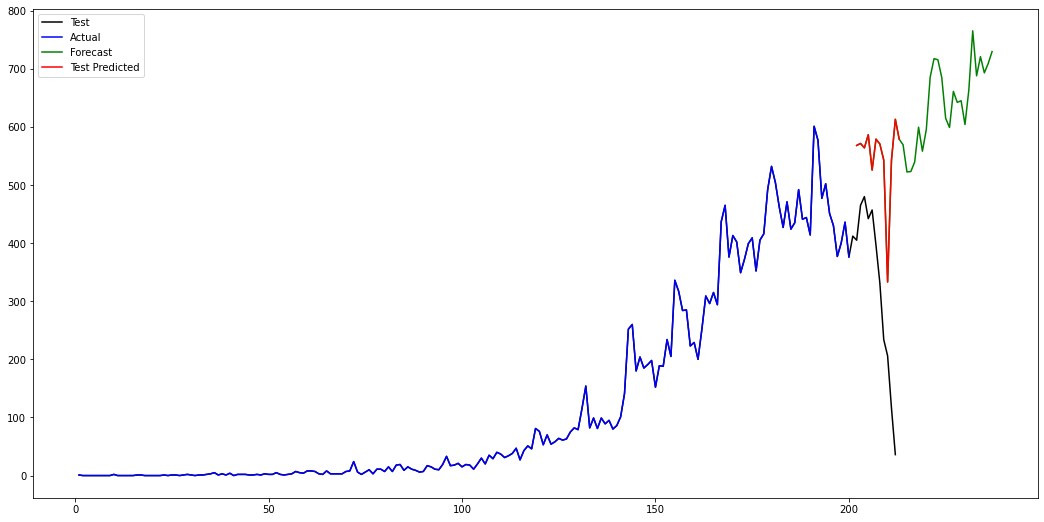

In [312]:
day_new=np.arange(1,201)
day_new1=np.arange(1,213)
day_pred=np.arange(202,202+12)
day_forecast=np.arange(202,202+36)
plt.figure(figsize=(18,9))
plt.plot(day_new1,neg_instrument['sentiment'],color='black',label='Test')
plt.plot(day_new,instrument_neg_train['sentiment'],color='b',label='Actual')
plt.plot(day_forecast,neg_forecast_instrument_36,color='green',label='Forecast')
plt.plot(day_pred,neg_forecast_instrument,color='red',label='Test Predicted')
plt.legend()
plt.show()

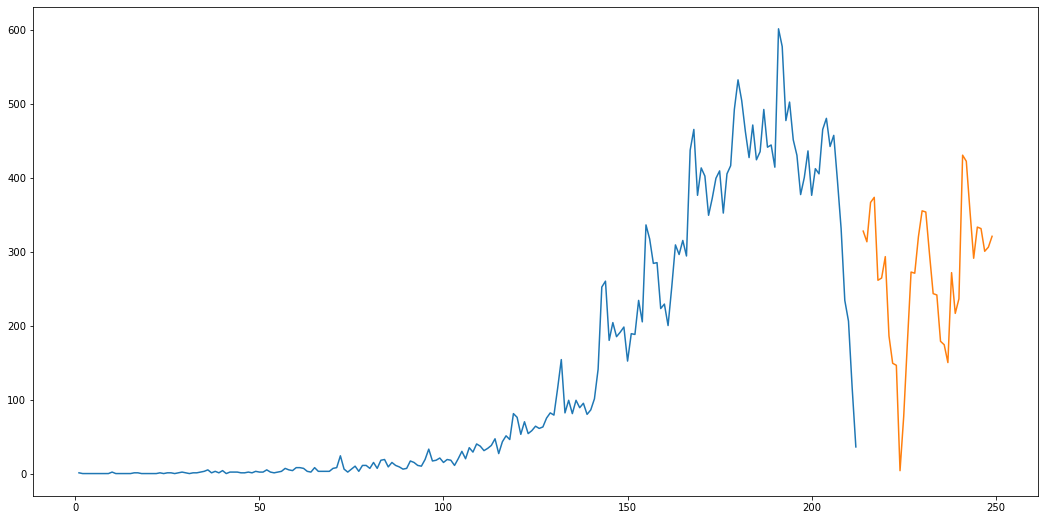

In [258]:
day_new=np.arange(1,213)
day_pred=np.arange(214,250)
plt.figure(figsize=(18,9))
plt.plot(day_new,neg_instrument['sentiment'])
plt.plot(day_pred,neg_forecast_instrument)
plt.show()